# Rigid image registration using cross-correlatation - PUBLIC VERSION

In this notebook, we register two images according to the rotation angle and the shift that we compute using cross-correlation

In [1]:
import os
import pandas as pd

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import cv2
from skimage.filters import frangi
from skimage.filters import meijering
from skimage.filters import sato
from skimage.transform import warp_polar, rotate, rescale
from skimage.registration import phase_cross_correlation
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_mutual_information
from skimage.feature import plot_matches

# 1. Load the data

Note: for illustrating the notebook, we use a couple of images that come from a public dataset.

#### Source image

Text(0.5, 1.0, 'public_source.jpg')

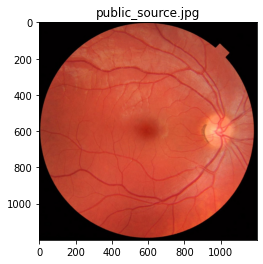

In [2]:
source_filename = "public_source.jpg"
source = Image.open(source_filename)
source = np.asarray(source)

plt.figure()
plt.imshow(source)
plt.title(source_filename)

#### Target image

Text(0.5, 1.0, 'public_target.jpg')

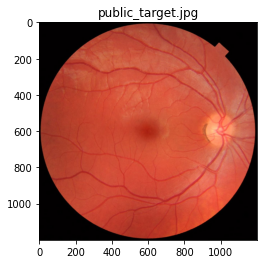

In [3]:
target_filename = "public_target.jpg"
target = Image.open(target_filename)
target = np.asarray(target)

plt.figure()
plt.imshow(target)
plt.title(target_filename)

In [4]:
print("Mutual information")
print(f"Target - Source : {normalized_mutual_information(target, source):.3f}")

print("\nMean squared error")
print(f"Target - Source : {mean_squared_error(target, source):.3f}")

Mutual information
Target - Source : 1.338

Mean squared error
Target - Source : 145.026


# 2. Preprocess the images

We transform color images into 2D-array, and enhance the vessels

## a) Test of four filters

We compare the output of four filters (canny, sato, frangi, meijering) on the target image

In [5]:
def vessel_filter(path, img_filename, filter='sato', color='gray'):
    """filter: canny, sato, frangi, meijering
       color: gray, channel0, channel1, channel2"""
    
    img = Image.open(path + img_filename)
    
    if color=='gray':
        img_arr = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
    elif color=='channel1':
        img_arr = np.asarray(img)[:,:,1]

    if filter=='canny':
        canny_img = cv2.Canny(img_arr, threshold1=20, threshold2=50)
        return canny_img
        
    elif filter=='sato':
        sato_img = sato(img_arr)
        return sato_img
    
    elif filter=='frangi':
        frangi_img = frangi(img_arr)
        return frangi_img
    
    elif filter=='meijering':
        meijering_img = meijering(img_arr)
        return meijering_img

### Filters applied on gray scale image

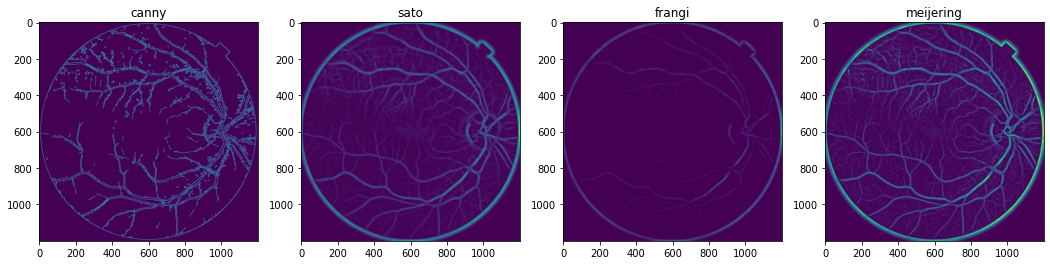

In [6]:
filters_names = ['canny', 'sato', 'frangi', 'meijering']

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,12))

for idx, name in enumerate(filters_names):
    sbplt = axs[idx]
    sbplt.set_title(name)
    sbplt.imshow(vessel_filter("", target_filename, filter=name, color='gray'))

### Filters applied on channel1 of the color image [:, :, 1]

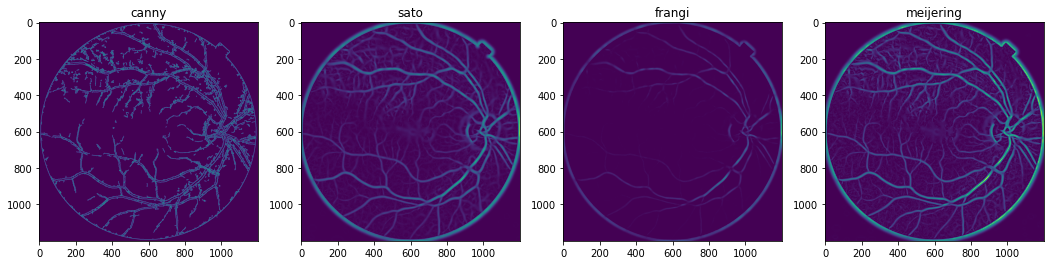

In [7]:
filters_names = ['canny', 'sato', 'frangi', 'meijering']

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,12))

for idx, name in enumerate(filters_names):
    sbplt = axs[idx]
    sbplt.set_title(name)
    sbplt.imshow(vessel_filter("", target_filename, filter=name, color='channel1'))

We observe that sato and meijering are the most appropriate filters for our image

## b) Result: Sato filter applied on gray image

For preprocessing, we do the following:

- convert to gray img
- apply sato
- remove background
- remove circle
- normalize / augment contrast

Note: the threshold to augment contrast and the radius of the circle to remove have to be adjusted depending on the images)

In [8]:
def sato_filter(img: np.array):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = sato(img)
    img[img>0.01] = 255
    img[img<0.01] = 0 # remove background
    img = cv2.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    def remove_circle(img):
        center = (int(img.shape[1]/2), int(img.shape[0]/2))
        radius = int(img.shape[0]/2) - 20
        mask = np.zeros(img.shape[:2], dtype="uint8")
        cv2.circle(mask, center, radius, 255, -1)
        return cv2.bitwise_and(img, img, mask=mask)

    img = remove_circle(img)
    height, width = img.shape
    return img

Text(0.5, 1.0, 'Preprocessed image')

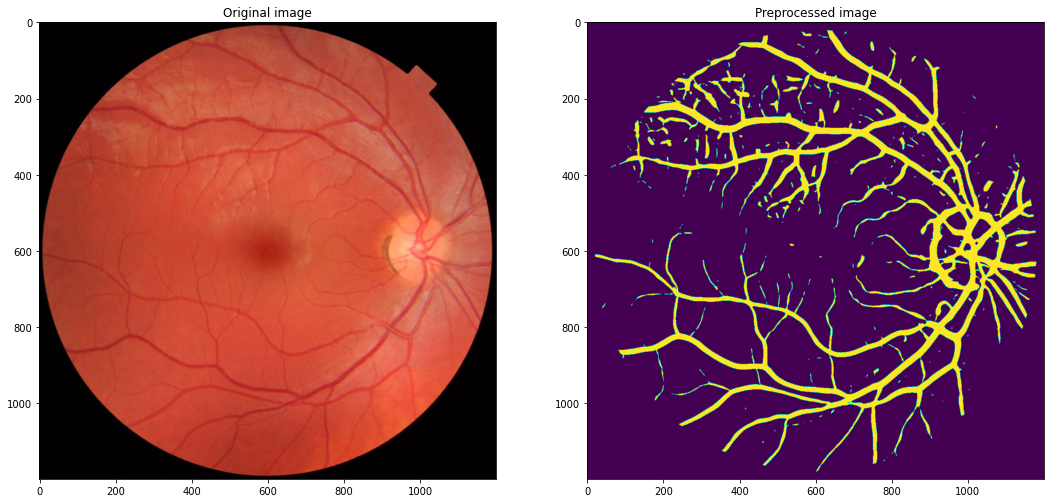

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,12))

axs[0].imshow(target)
axs[0].set_title("Original image")

axs[1].imshow(sato_filter(target))
axs[1].set_title("Preprocessed image")

# 3. Image registration

We proceed as follows:

1. Computation of the angle of rotation between the source image and the target image
2. Rotation of the source image
3. Computation of the shift between the rotated image and the target image
4. Alignment of the source image

## a) Computation of the rotation angle, and rotation of the source image

In [10]:
def imageRegistration_rotation(source, source_filtered, target_filtered):
    radius = int(target_filtered.shape[0]/2) - 20

    source_filtered_polar = warp_polar(source_filtered, radius=radius)
    target_filtered_polar = warp_polar(target_filtered, radius=radius)
    
    shifts, error, diffphase = phase_cross_correlation(target_filtered_polar, source_filtered_polar)
    shift_angle, shift_scale = shifts[:2]

    angle = (360/(target_filtered.shape[0])) * shift_angle
    print("Angle: ", angle)
    klog = radius / np.log(radius)
    scale = 1 / np.exp(shift_scale/klog)
    #print("Scale: ", scale)

    source_rotated = rotate(source, -shift_angle, resize=True)
    source_filtered_rotated = rotate(source_filtered, -shift_angle, resize=True)
    
    def resize(img, target_shape): # when target shape smaller than img shape
        margin_x = int((img.shape[0]-target_shape[0]) / 2)
        margin_y = int((img.shape[1]-target_shape[1]) / 2)
        resized_img = img[margin_x:margin_x+target_shape[0], margin_y:margin_y+target_shape[1]]
        return resized_img

    if source_filtered_rotated.shape[0] > source_filtered.shape[0]:
        target_shape = source_filtered.shape
        source_rotated = resize(source_rotated, target_shape)
        source_filtered_rotated = resize(source_filtered_rotated, target_shape)
    
    source_filtered_rotated = cv2.normalize(src=source_filtered_rotated,
                                            dst=None, alpha=0, beta=255,
                                            norm_type=cv2.NORM_MINMAX,
                                            dtype=cv2.CV_8U)

    return source_rotated, source_filtered_rotated, angle

In [11]:
source_filtered = sato_filter(source)
target_filtered = sato_filter(target)

source_rotated, source_filtered_rotated, angle = imageRegistration_rotation(source,
                                                                            source_filtered,
                                                                            target_filtered)

Angle:  -0.3


Text(0.5, 1.0, 'Layering of the rotated source and the target (angle=-0.3)')

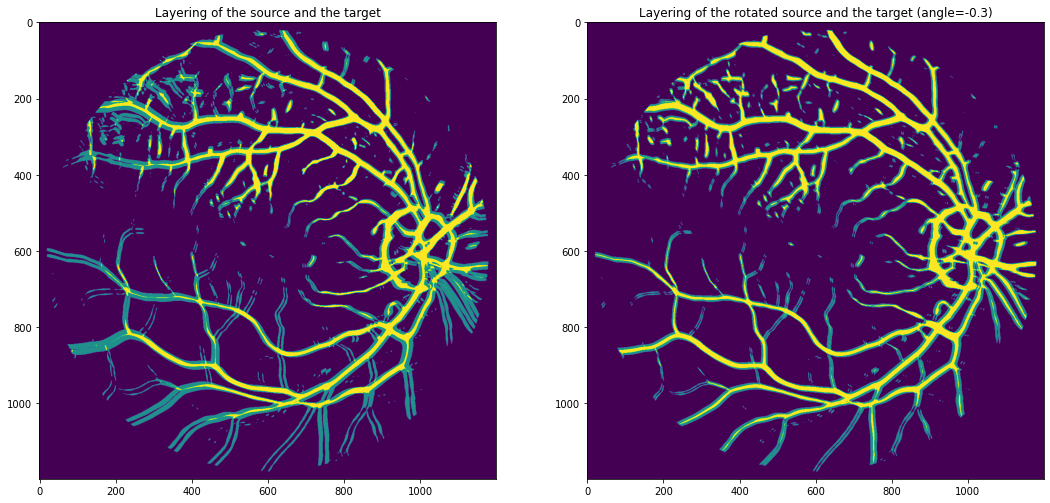

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,12))

axs[0].imshow(cv2.addWeighted(source_filtered, 0.5, target_filtered, 0.5, 0))
axs[0].set_title("Layering of the source and the target")

axs[1].imshow(cv2.addWeighted(source_filtered_rotated, 0.5, target_filtered, 0.5, 0))
axs[1].set_title("Layering of the rotated source and the target (angle=" + str(angle) + ")")

## b) Computation of the shift and alignment

In [13]:
def imageRegistration_crossCorrelation(source, source_filtered, target_filtered):
    
    shift, error, diffphase = phase_cross_correlation(target_filtered, source_filtered)
    print("Shift: ", shift)

    def shift_image(img, shift):
        dx, dy = shift
        dx = int(dx)
        dy = int(dy)
        Lx, Ly = img.shape
        img = np.roll(img, dx, axis=0)
        img = np.roll(img, dy, axis=1)
        if dx>0:
            img[:dx, :] = 0
        elif dx<0:
            img[Lx-dx:, :] = 0
        if dy>0:
            img[:, :dy] = 0
        elif dx<0:
            img[:, Ly-dy:] = 0
        return img

    source_moved_0 = shift_image(source[:,:,0], shift)
    source_moved_1 = shift_image(source[:,:,1], shift)
    source_moved_2 = shift_image(source[:,:,2], shift)
    source_moved = np.dstack([source_moved_0, source_moved_1, source_moved_2])

    source_filtered_moved = shift_image(source_filtered, shift)

    
    return source_moved, source_filtered_moved, shift

In [14]:
source_moved, source_filtered_moved, shift = imageRegistration_crossCorrelation(source_rotated,
                                                                                source_filtered_rotated,
                                                                                target_filtered)

Shift:  [3. 3.]


Text(0.5, 1.0, 'Layering of the registered source (rotated+moved) and the target (shift=[3. 3.])')

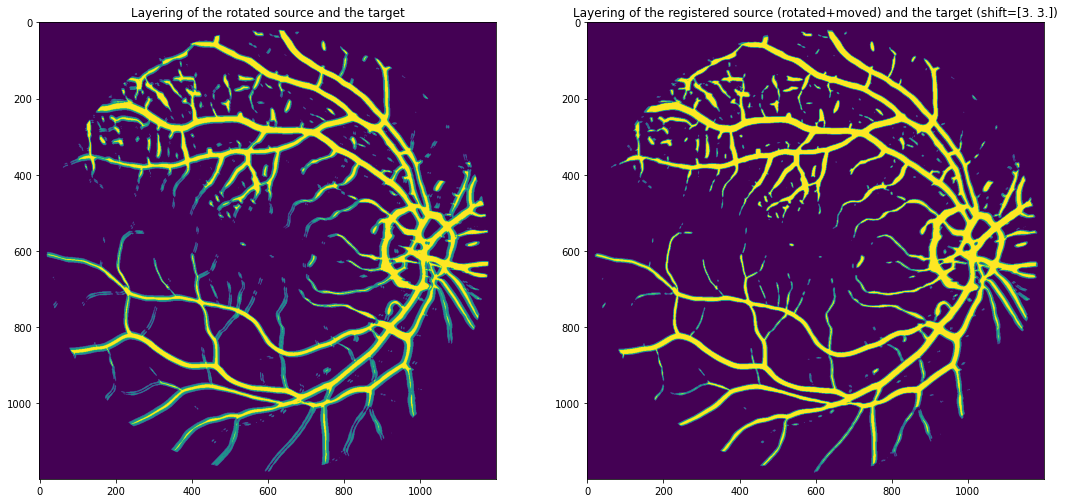

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,12))

axs[0].imshow(cv2.addWeighted(source_filtered_rotated, 0.5, target_filtered, 0.5, 0))
axs[0].set_title("Layering of the rotated source and the target")

axs[1].imshow(cv2.addWeighted(source_filtered_moved, 0.5, target_filtered, 0.5, 0))
axs[1].set_title("Layering of the registered source (rotated+moved) and the target (shift=" + str(shift) + ")")

## Result: Output after rotating and aligning

Text(0.5, 1.0, 'Target')

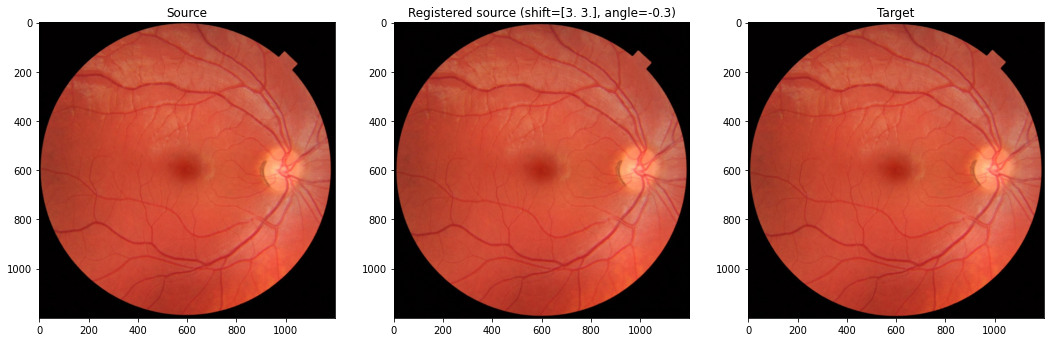

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,12))

axs[0].imshow(source)
axs[0].set_title("Source")

axs[1].imshow(source_moved)
axs[1].set_title("Registered source (shift=" + str(shift) + ", angle=" + str(round(angle, 2)) + ")")

axs[2].imshow(target)
axs[2].set_title("Target")

In [17]:
print("Mutual information")
print(f"Target - Source : {normalized_mutual_information(target, source):.3f}")
print(f"Target - Moved  : {normalized_mutual_information(target, source_moved):.3f}")

print("\nMean squared error")
print(f"Target - Source : {mean_squared_error(target, source):.3f}")
print(f"Target - Moved  : {mean_squared_error(target, source_moved):.3f}")

Mutual information
Target - Source : 1.338
Target - Moved  : 1.480

Mean squared error
Target - Source : 145.026
Target - Moved  : 12976.777
